# Redução da Dimensionalidade

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from yellowbrick.model_selection import (
    ValidationCurve,
)

url = ("https://hbiostat.org/data/repo/titanic3.csv")

df = pd.read_csv(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
pca = PCA(random_state=42)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

In [4]:
pca.explained_variance_ratio_

array([0.23922843, 0.21616844, 0.19231579, 0.10464906, 0.08154794,
       0.07272212, 0.05130716, 0.04206105])

O primeiro componente principal explica aproximadamente 23.92% da variância total nos dados.

O segundo componente principal explica cerca de 21.62% da variância total.

O terceiro componente principal explica cerca de 19.23% da variância total.

O quarto componente principal explica aproximadamente 10.46% da variância total.

O quinto componente principal explica cerca de 8.15% da variância total.

O sexto componente principal explica cerca de 7.27% da variância total.

O sétimo componente principal explica aproximadamente 5.13% da variância total.

O oitavo componente principal explica cerca de 4.21% da variância total.

A variância é uma medida estatística que descreve a dispersão ou a amplitude dos valores em um conjunto de dados. Em outras palavras, a variância indica o quão distantes os diferentes valores estão da média do conjunto de dados. Ela é calculada como a média dos quadrados das diferenças entre cada valor e a média.

In [6]:
pca.components_[0]

array([-0.63274144,  0.39602225,  0.00653638,  0.11500343,  0.58150279,
       -0.19764918, -0.20422283, -0.10304595])

[Text(0.5, 0, 'Component'),
 Text(0, 0.5, 'Percent of Explained Variance'),
 Text(0.5, 1.0, 'Scree Plot'),
 (0.0, 1.0)]

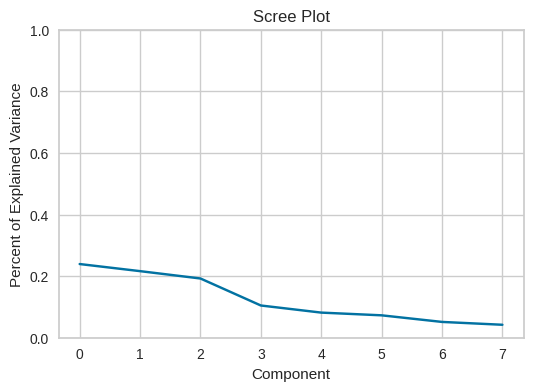

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(pca.explained_variance_ratio_)

ax.set(
    xlabel = "Component",
    ylabel = "Percent of Explained Variance",
    title = "Scree Plot",
    ylim = (0, 1),
)

[Text(0.5, 0, 'Component'),
 Text(0, 0.5, 'Percent of Explained Variance'),
 Text(0.5, 1.0, 'Cumulative Explained Variance'),
 (0.0, 1.0)]

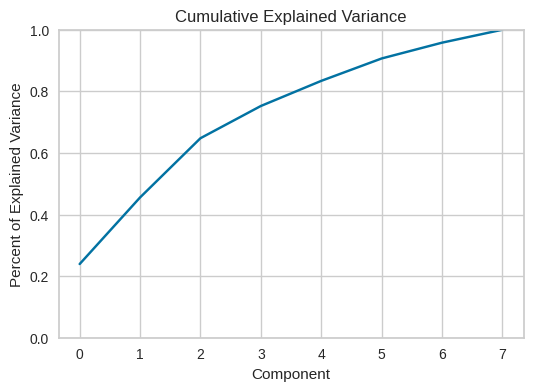

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    np.cumsum(pca.explained_variance_ratio_)
)

ax.set(
    xlabel = "Component",
    ylabel = "Percent of Explained Variance",
    title = "Cumulative Explained Variance",
    ylim = (0, 1),
)

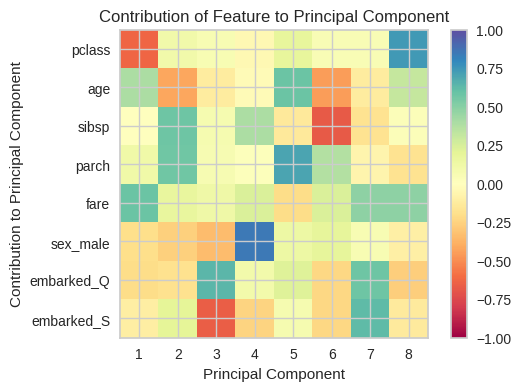

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.imshow(
    pca.components_.T,
    cmap="Spectral",
    vmin=-1,
    vmax=1
)

plt.yticks(range(len(X.columns)), X.columns)
plt.xticks(range(8), range(1,9))

plt.xlabel("Principal Component")
plt.ylabel("Contribution to Principal Component")

plt.title(
    "Contribution of Feature to Principal Component"
)

plt.colorbar()

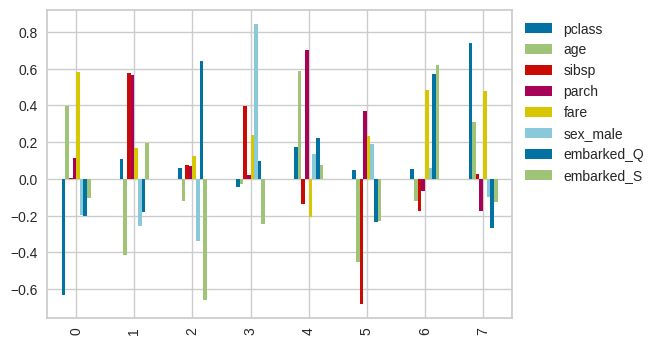

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

pd.DataFrame(
    pca.components_, columns=X.columns
).plot(kind="bar", ax=ax).legend(
    bbox_to_anchor=(1, 1)
)

In [15]:
comps = pd.DataFrame(
    pca.components_, columns=X.columns
)

min_val = 0.5 # altere para o valor mínimo que deseja
num_comps = 2 # altere para o número de componentes que deseja

pca_cols = set()

for i in range(num_comps):
    parts = comps.iloc[i][
        comps.iloc[i].abs() > min_val
    ]

    pca_cols.update(set(parts.index))

pca_cols

{'fare', 'parch', 'pclass', 'sibsp'}

In [16]:
from yellowbrick.features.pca import PCADecomposition

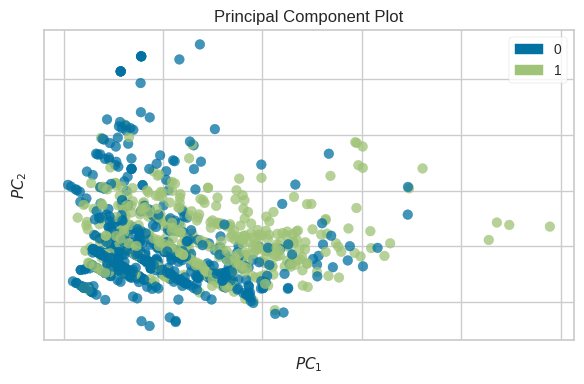

<Axes: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))

colors = ["rg"[j] for j in y]

pca_viz = PCADecomposition(color=colors)
pca_viz.fit_transform(X, y)

pca_viz.show()

In [20]:
import seaborn as sns

<Axes: xlabel='PC1', ylabel='PC2'>

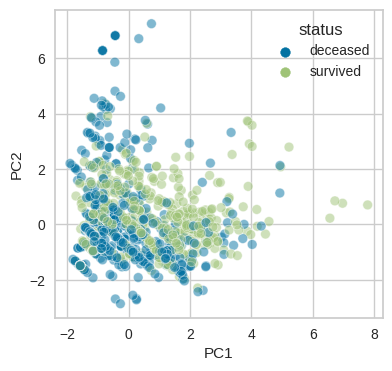

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))

pca_df = pd.DataFrame(
    X_pca,
    columns=[
        f"PC{i+1}" for i in range(X_pca.shape[1])
    ],
)

pca_df['status'] = [
    ('deceased' , 'survived')[i] for i in y
]

evr = pca.explained_variance_ratio_

ax.set_aspect(evr[1] / evr[0])

sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="status",
    data = pca_df,
    alpha=0.5,
    ax=ax,
)

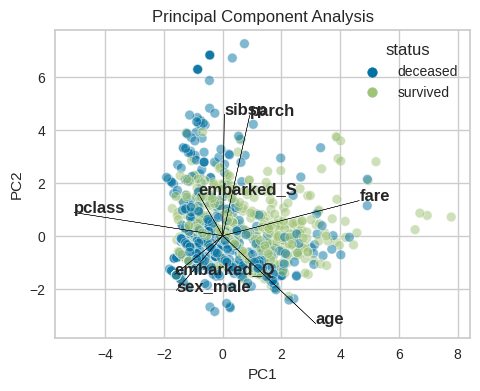

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Principal Component Analysis")

pca_df = pd.DataFrame(
    X_pca,
    columns = [
        f"PC{i+1}" for i in range(X_pca.shape[1])
    ],
)

pca_df['status'] = [
    ('deceased', 'survived')[i] for i in y
]

evr = pca.explained_variance_ratio_

x_idx = 0 # x_pc
y_idx = 1 # y_pc

ax.set_aspect(evr[y_idx] / evr[x_idx])
x_col = pca_df.columns[x_idx]
y_col = pca_df.columns[y_idx]

sns.scatterplot(
    x=x_col,
    y=y_col,
    hue="status",
    data=pca_df,
    alpha=0.5,
    ax=ax,
)

scale = 8
comps = pd.DataFrame(
    pca.components_, columns=X.columns
)

for idx, s in comps.T.iterrows():
    plt.arrow(
        0,
        0,
        s[x_idx] * scale,
        s[y_idx] * scale,
        color="k",
    )
    plt.text(
        s[x_idx] * scale,
        s[y_idx] * scale,
        idx,
        weight="bold",
    )

<Axes: xlabel='PC1', ylabel='PC4'>

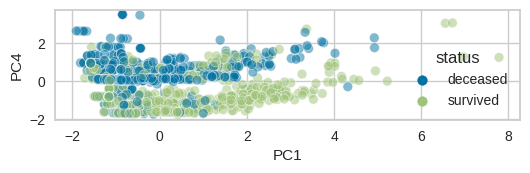

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
pca_df = pd.DataFrame(
    X_pca,
    columns=[
        f"PC{i+1}" for i in range(X_pca.shape[1])
    ],
)

pca_df['status'] = [
    ('deceased', 'survived')[i] for i in y
]

evr = pca.explained_variance_ratio_

ax.set_aspect(evr[3] / evr[0])

sns.scatterplot(
    x="PC1",
    y="PC4",
    hue="status",
    data=pca_df,
    alpha=0.5,
    ax=ax,
)